# Image restoration / segmentation project
# in this project, there are three parts:
* we keep the A example to let readers understand better the principle of maxflow cut
* the apple examples is about using boundart condictions of prior knowledge
* the restoration is a practice of multiple layers
* the stereo images are meant to try different $D_p(q)$

### Flow network from an image

Flow network can be directly computed from an image, which is very convenient:
http://pmneila.github.io/PyMaxflow/maxflow.html

We use as example a noisy image of the letter A:


<img src="a2.png" alt="Graph result" style="width: 80px;"/>

In [28]:
import numpy as np
import scipy
import scipy.misc
import imageio
#from matplotlib.pyplot import imread
#from scipy.misc import imread
#from scipy.misc.pilutil import imread
img=imageio.imread("a2.png")
img=img[20:23,20:23]
#plt.figure(figsize=(2,2))
#plt.imshow(img)
import maxflow

#img = imread("a2.png")

### Image restoration

We will restore the image minimizing the energy

$$E(\mathbf{x}) = \sum_i D_i(x_i) + \lambda \sum_{(i,j)\in\mathcal{C}} |x_i - x_j|$$,

where $\mathbf{x} \in \{0,1\}^N$ are the values of the restored image, $N$ is the number of pixels. The unary term $D_i(0)$ (resp $D_i(1)$) is the penalty for assigning the value 0 (resp 1) to the i-th pixel. Each $D_i$ depends on the values of the noisy image, which are denoted as $p_i$:

$D_i(x_i)$ = \begin{cases} p_i & \textrm{if } x_i=0\\ 
255-p_i & \textrm{if } x_i=1 \end{cases}.

Thus, $D_i$ is low when assigning the label 0 to dark pixels or the label 1 to bright pixels, and high otherwise. The value $\lambda$ is the regularization strength. The larger $\lambda$ the smoother the restoration. We set it to 50. This $\lambda$ does not need to be a fixed constant for every pixel, but in this case it is. It may not depend on $\mathbf{x}$.

The maximum flow algorithm is widely used to minimize energy functions of this type. We build a graph which represents the above energy. This graph has as many non-terminal nodes as pixels in the image. The nodes are connected in a grid arrangement, so that the nodes corresponding to neighbor pixels are connected by a forward and a backward edge. The capacities of all non-terminal edges is $\lambda$. The capacities of the edges from the source node are set to $D_i(0)$, and the capacities of the edges to the sink node are $D_i(1)$.

We could build this graph as in the first example. First, we would add all the nodes. Then, we would iterate over the nodes adding the edges properly. However, this is extremely slow in Python, especially when dealing with large images or stacks of images. PyMaxflow provides methods for building some complex graphs with a few calls. In this example we review add_grid_nodes, add_grid_edges, which add edges with a fixed capacity to the grid, and add_grid_tedges, which sets the capacities of the terminal edges for multiple nodes:

black is 0

In [27]:
#test cell and graph comstruction practice
img.shape

(0, 64)

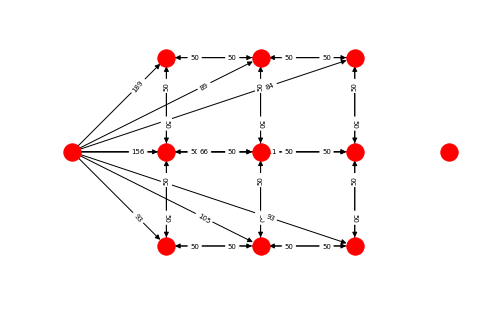

In [37]:
# Create the graph.
g = maxflow.Graph[int]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img.shape)
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, 50)
# Add the terminal edges. The image pixels are the capacities
# of the edges from the source node. The inverted image pixels
# are the capacities of the edges to the sink node.
g.add_grid_tedges(nodeids, img, img-img)
plot_graph_2d(g,(img.shape[0],img.shape[1]))

Finally, we perform the maxflow computation and get the results:

In [24]:
# Find the maximum flow.
g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)

The method get_grid_segments returns an array with the same shape than nodeids. It is almost equivalent to calling get_segment once for each node in nodeids, but much faster. For the i-th cell, the array stores False if the i-th node belongs to the source segment (i.e., the corresponding pixel has the label 1) and True if the node belongs to the sink segment (i.e., the corresponding pixel has the label 0). We now get the labels for each pixel:

<IPython.core.display.Javascript object>


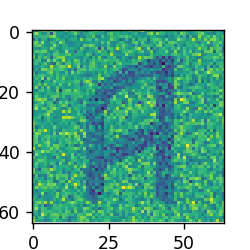

<IPython.core.display.Javascript object>


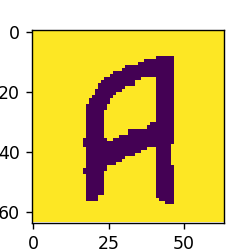

In [25]:
%matplotlib notebook
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.
from matplotlib import pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(img)
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.show()

## Apply the above code on appel image with several improvement, such as image io
## the results show the above definition of energy does not work because the apple has the same brightness as background, however the grapes are easily distinguished

<IPython.core.display.Javascript object>


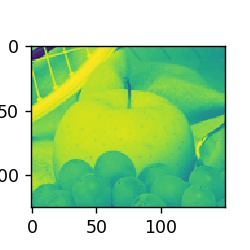

shape of apple img(125, 150)


In [26]:
import numpy as np
import scipy
import scipy.misc
import imageio

img=imageio.imread("apple150.pgm")
#plt.figure(figsize=(2,2))
#plt.imshow(img)
import maxflow
plt.figure(figsize=(2,2))
plt.imshow(img)
print("shape of apple img{}".format(img.shape))


<IPython.core.display.Javascript object>


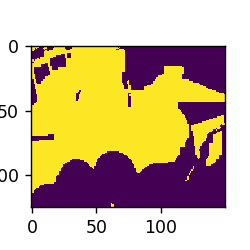

In [27]:
# Create the graph.
g = maxflow.Graph[int]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img.shape)
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, 20)
# Add the terminal edges. The image pixels are the capacities
# of the edges from the source node. The inverted image pixels
# are the capacities of the edges to the sink node.
g.add_grid_tedges(nodeids, 2*img, 2*(255-img))
# Find the maximum flow.
g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
%matplotlib notebook
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.show()

## We notice that the outline of apple can not be detected since the apple has similar color with background, so we will add some constraint by using the seed picture
## we need to understand the color definition firstly, then we extract the dark and bright pre-defined boundary
## Finally we construct a more complex graph to do the max-flow cut

<IPython.core.display.Javascript object>


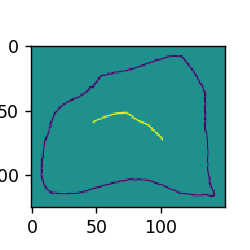

shape of seed_apple img(125, 150)
color value 128 has 150 occurence
color value 128 has 150 occurence
color value 128 has 150 occurence
color value 128 has 150 occurence
color value 128 has 150 occurence
color value 128 has 150 occurence
color value 128 has 150 occurence
color value 113 has 5 occurence
color value 116 has 1 occurence
color value 120 has 1 occurence
color value 127 has 2 occurence
color value 128 has 141 occurence
color value 0 has 1 occurence
color value 2 has 1 occurence
color value 5 has 1 occurence
color value 6 has 2 occurence
color value 7 has 1 occurence
color value 14 has 1 occurence
color value 28 has 1 occurence
color value 30 has 3 occurence
color value 42 has 1 occurence
color value 99 has 1 occurence
color value 101 has 1 occurence
color value 127 has 1 occurence
color value 128 has 135 occurence
color value 0 has 1 occurence
color value 19 has 1 occurence
color value 33 has 1 occurence
color value 37 has 1 occurence
color value 46 has 1 occurence
color val

color value 7 has 1 occurence
color value 12 has 1 occurence
color value 71 has 1 occurence
color value 75 has 1 occurence
color value 77 has 1 occurence
color value 112 has 2 occurence
color value 120 has 1 occurence
color value 128 has 142 occurence
color value 0 has 3 occurence
color value 12 has 1 occurence
color value 19 has 1 occurence
color value 60 has 1 occurence
color value 115 has 1 occurence
color value 120 has 1 occurence
color value 122 has 1 occurence
color value 128 has 141 occurence
color value 16 has 1 occurence
color value 59 has 1 occurence
color value 60 has 1 occurence
color value 81 has 1 occurence
color value 88 has 3 occurence
color value 126 has 1 occurence
color value 128 has 142 occurence
color value 1 has 1 occurence
color value 3 has 1 occurence
color value 12 has 1 occurence
color value 70 has 1 occurence
color value 91 has 1 occurence
color value 105 has 1 occurence
color value 120 has 1 occurence
color value 128 has 143 occurence
color value 4 has 1 occ

color value 153 has 1 occurence
color value 178 has 1 occurence
color value 184 has 1 occurence
color value 186 has 1 occurence
color value 212 has 1 occurence
color value 215 has 1 occurence
color value 22 has 1 occurence
color value 31 has 1 occurence
color value 68 has 1 occurence
color value 87 has 1 occurence
color value 127 has 1 occurence
color value 128 has 134 occurence
color value 130 has 1 occurence
color value 137 has 1 occurence
color value 149 has 1 occurence
color value 161 has 1 occurence
color value 164 has 1 occurence
color value 197 has 1 occurence
color value 205 has 1 occurence
color value 8 has 1 occurence
color value 32 has 1 occurence
color value 72 has 1 occurence
color value 87 has 1 occurence
color value 112 has 1 occurence
color value 128 has 134 occurence
color value 132 has 1 occurence
color value 134 has 1 occurence
color value 147 has 1 occurence
color value 168 has 1 occurence
color value 172 has 1 occurence
color value 183 has 1 occurence
color value 1

color value 128 has 146 occurence
color value 5 has 1 occurence
color value 27 has 1 occurence
color value 66 has 1 occurence
color value 105 has 1 occurence
color value 128 has 146 occurence
color value 5 has 1 occurence
color value 52 has 1 occurence
color value 66 has 1 occurence
color value 113 has 1 occurence
color value 128 has 146 occurence
color value 5 has 1 occurence
color value 6 has 1 occurence
color value 66 has 1 occurence
color value 68 has 1 occurence
color value 128 has 146 occurence
color value 6 has 1 occurence
color value 41 has 1 occurence
color value 48 has 1 occurence
color value 109 has 1 occurence
color value 128 has 146 occurence
color value 13 has 1 occurence
color value 22 has 1 occurence
color value 73 has 1 occurence
color value 90 has 1 occurence
color value 128 has 146 occurence
color value 13 has 1 occurence
color value 52 has 1 occurence
color value 66 has 1 occurence
color value 97 has 1 occurence
color value 118 has 1 occurence
color value 128 has 14

color value 30 has 1 occurence
color value 33 has 4 occurence
color value 46 has 1 occurence
color value 48 has 1 occurence
color value 52 has 1 occurence
color value 62 has 1 occurence
color value 75 has 1 occurence
color value 85 has 1 occurence
color value 90 has 1 occurence
color value 95 has 1 occurence
color value 104 has 2 occurence
color value 116 has 1 occurence
color value 124 has 6 occurence
color value 126 has 1 occurence
color value 127 has 1 occurence
color value 128 has 103 occurence
color value 0 has 6 occurence
color value 4 has 1 occurence
color value 6 has 1 occurence
color value 19 has 1 occurence
color value 26 has 1 occurence
color value 37 has 1 occurence
color value 40 has 3 occurence
color value 42 has 5 occurence
color value 56 has 1 occurence
color value 69 has 1 occurence
color value 79 has 1 occurence
color value 86 has 5 occurence
color value 101 has 2 occurence
color value 103 has 1 occurence
color value 112 has 1 occurence
color value 124 has 1 occurence

In [28]:
# to understand the value and corresponding color
# do not run it twice- it takes time- the results is shown below
img_seed=imageio.imread("seed_apple.pgm")
plt.figure(figsize=(2,2))
plt.imshow(img_seed)
print("shape of seed_apple img{}".format(img_seed.shape))
#we count the occurence of img_seed
for i in range (125):
    for j in range(225):
        if(list(img_seed[i]).count(j)!=0):
            print("color value {} has {} occurence".format(j,list(img_seed[i]).count(j)))

<IPython.core.display.Javascript object>


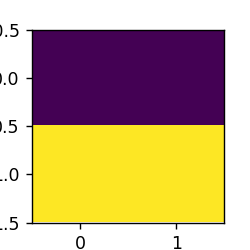

In [64]:
#color understanding
plt.figure(figsize=(2,2))
plt.imshow(np.array([[3,3],[230,230]]))
#0 is dark, 255 is light

In [125]:
# get dark color index
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x > y]
rowIndex=np.array([])
colIndex=np.array([])
for i in range(img_seed.shape[0]):
    colIndex_ite=get_indexes(110,img_seed[i])
    rowIndex_ite=(np.ones(len(colIndex_ite)))*i
    rowIndex=np.hstack((rowIndex,rowIndex_ite))
    colIndex=np.hstack((colIndex,colIndex_ite))


<IPython.core.display.Javascript object>


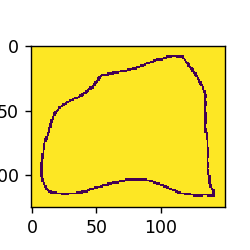

In [126]:
#check whether the darker line is correctly found
test_img=np.ones(img_seed.shape)*128
for i in range(len(rowIndex)):
        test_img[int(rowIndex[i])][int(colIndex[i])]=0

plt.figure(figsize=(2,2))
plt.imshow(test_img)
# correct

<IPython.core.display.Javascript object>


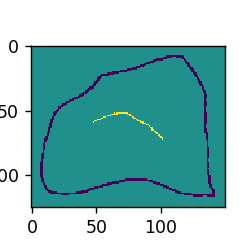

In [127]:
# find light color index and test
# get dark color index
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x < y]
rowIndex_light=np.array([])
colIndex_light=np.array([])
for i in range(img_seed.shape[0]):
    colIndex_ite=get_indexes(200,img_seed[i])
    rowIndex_ite=(np.ones(len(colIndex_ite)))*i
    rowIndex_light=np.hstack((rowIndex_light,rowIndex_ite))
    colIndex_light=np.hstack((colIndex_light,colIndex_ite))
    
for i in range(len(rowIndex_light)):
    test_img[int(rowIndex_light[i])][int(colIndex_light[i])]=255

plt.figure(figsize=(2,2))
plt.imshow(test_img)

Then we construct the graph by impulsing boundary condiction

F:\software\2PYTHON\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app


[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         146.7932777  147.15283042 ... 146.08038346 146.20500512
    0.        ]
 [  0.         147.12282399 145.74765777 ... 145.70551633 145.89005433
    0.        ]
 ...
 [  0.         147.38935069 145.94872851 ... 147.39335776 147.38532787
    0.        ]
 [  0.         145.71611374 145.86019545 ... 147.40132492 145.74765777
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


<IPython.core.display.Javascript object>


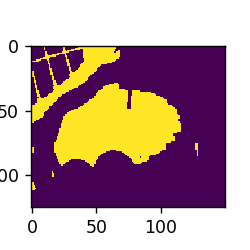

<IPython.core.display.Javascript object>


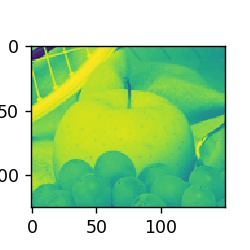

In [201]:
# we consider sink is 1 representing the bright color
img=imageio.imread("apple150.pgm")
#g = maxflow.Graph[int](len(rowIndex)+len(rowIndex_light), img.shape[0]*img.shape[1]-len(rowIndex)+len(rowIndex_light))
g=maxflow.Graph[int]()
nodeids = g.add_grid_nodes(img.shape)
structure = np.array([[0, 0, 0],
                      [0, 0, 1],
                      [0, 1, 0]])

# a reward penality for similarity -->give weight to neibours
weights=np.zeros(img.shape)
for i in range(weight.shape[0]-2):
    for j in range(weight.shape[1]-2):
        weights[i+1][j+1]=np.exp(5)-np.exp((np.abs(img[i+1][j+1]-img[i+1][j])+np.abs(img[i+1][j+1]-img[i-1][j])+
                                        np.abs(img[i+1][j+1]-img[i][j-1])+np.abs(img[i+1][j+1]-img[i][j+1]))/255)

#print(weights)
g.add_grid_edges(nodeids, weights=weights/5, structure=structure,symmetric=False)
#g.add_grid_edges(nodeids, 1)
#notice that the grapes are bright(>128, so we introduce a corretion term(3))

#background as darker than apple
g.add_grid_tedges(nodeids,3*img, 3*(258-img))

#link the dark boundary together with great weight
for i in range(len(rowIndex)-1):
    g.add_edge(nodeids[int(rowIndex[i])][int(colIndex[i])],nodeids[int(rowIndex[i+1])][int(colIndex[i+1])],2000000,2000000)
    for j in range(8):
        g.add_edge(nodeids[int(rowIndex[i])+j][int(colIndex[i])],nodeids[int(rowIndex[i+1])+j][int(colIndex[i+1])],2000000,2000000)
        g.add_edge(nodeids[int(rowIndex[i])][int(colIndex[i])+j],nodeids[int(rowIndex[i+1])][int(colIndex[i+1])+j],2000000,2000000)
        g.add_edge(nodeids[int(rowIndex[i])-j][int(colIndex[i])],nodeids[int(rowIndex[i+1])-j][int(colIndex[i+1])],2000000,2000000)
        g.add_edge(nodeids[int(rowIndex[i])][int(colIndex[i])-j],nodeids[int(rowIndex[i+1])][int(colIndex[i+1])-j],2000000,2000000)
   
    
g.add_tedge(nodeids[int(rowIndex[0])][int(colIndex[0])],1,50000000)

#link the light boundary
for i in range(len(rowIndex_light)-1):
    g.add_edge(nodeids[int(rowIndex_light[i])][int(colIndex_light[i])],nodeids[int(rowIndex_light[i+1])][int(colIndex_light[i+1])],200,200)

g.add_tedge(nodeids[int(rowIndex_light[0])][int(colIndex_light[0])],500,1)



g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
%matplotlib notebook
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()


## Here is the best result so far, Reading more concerning article about energy function might be helpful.

## Image restoration

<IPython.core.display.Javascript object>


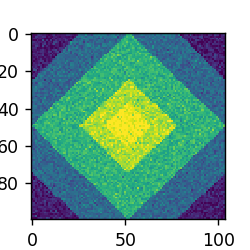

shape of pyramid img(100, 104)
[[17 25 38 ... 24 23  2]
 [19  6 12 ...  0 27 39]
 [18  4 46 ...  0 26 18]
 ...
 [ 8  0  0 ... 25 11  5]
 [33 25 67 ... 12  0 15]
 [ 5  3  0 ... 21  0 26]]


In [337]:
import numpy as np
import scipy
import scipy.misc
import imageio

img=imageio.imread("pyramid_agwn_sat_255.png")
#plt.figure(figsize=(2,2))
#plt.imshow(img)
import maxflow
plt.figure(figsize=(2,2))
plt.imshow(img)
print("shape of pyramid img{}".format(img.shape))
print(img)


# construct a 2-connect graph- result-very bad (seg is mostly of one value)

In [382]:
# Create the graph.
g = maxflow.Graph[int]()
# num_label=5,k=5
nodeids = g.add_grid_nodes((4,img.shape[0]*img.shape[1]))
print(img.shape)
print(nodeids)
def unrevel(nodenum,img):
    x=nodenum//img.shape[1]
    y=nodenum%img.shape[1]
    return(x,y)
unrevel(10399,img)[1]

(100, 104)
[[    0     1     2 ... 10397 10398 10399]
 [10400 10401 10402 ... 20797 20798 20799]
 [20800 20801 20802 ... 31197 31198 31199]
 [31200 31201 31202 ... 41597 41598 41599]]


103

In [378]:
#add n-link 
k=5
threshold=20
lamb=10
#we divide by 2 to avoid overflow problem
for j in range(nodeids.shape[1]-1):
    #print(j)
    if (np.abs(img[unrevel(nodeids[0][j],img)[0]][unrevel(nodeids[0][j],img)[1]]/2-
            img[unrevel(nodeids[0][j+1],img)[0]][unrevel(nodeids[0][j+1],img)[1]]/2)<threshold):
        #print("smaller than threshold{}".format(lamb))
        for i in range(nodeids.shape[0]):
            g.add_edge(nodeids[i][j],nodeids[i][j+1],lamb,lamb)
            #print(nodeids[i][j],nodeids[i][j+1])
        else:
            for i in range(nodeids.shape[0]):
                g.add_edge(nodeids[i][j],nodeids[i][j+1],2*lamb,2*lamb)


In [370]:
#add t-link
#we give a 10000 to the edge sink(src)-p1
kp=(k-1)*4*2*lamb
for j in range(nodeids.shape[1]):
    g.add_tedge(nodeids[0][j],kp+(65-img[unrevel(nodeids[0][j],img)[0]][unrevel(nodeids[0][j],img)[1]])**2,1)
    
#link the sink
for j in range(nodeids.shape[1]):
    g.add_tedge(nodeids[nodeids.shape[0]-1][j],1,kp+(225-img[unrevel(nodeids[0][j],img)[0]][unrevel(nodeids[0][j],img)[1]])**2)
    #print(nodeids[nodeids.shape[0]-1][j])
    
#p1-p2
for i in range(k-3):
    for j in range(nodeids.shape[1]):
        g.add_edge(nodeids[i+1][j],nodeids[i+2][j],kp+(65+40*i-img[unrevel(nodeids[0][j],img)[0]][unrevel(nodeids[0][j],img)[1]])**2,
                   kp+(65+40*i-img[unrevel(nodeids[0][j],img)[0]][unrevel(nodeids[0][j],img)[1]])**2)
g.maxflow()
sgm = g.get_grid_segments(nodeids)
sgm


<function GraphInt.get_nx_graph>

[[105. 105. 105. ... 105. 105. 105.]
 [105. 105. 105. ... 105. 105. 105.]
 [105. 105. 105. ... 105. 105. 105.]
 ...
 [105. 105. 105. ... 105. 105. 105.]
 [105. 105. 105. ... 105. 105. 105.]
 [105. 105. 105. ... 105. 105. 105.]]


<IPython.core.display.Javascript object>


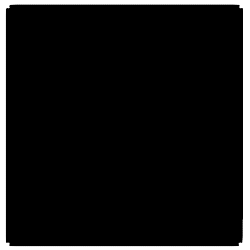

In [395]:
# reconstruction
#The method get_segment returns 1 when the given node belongs to the partition of the source node
#so for each col, all false means that there is a cut between source and P1
img2=np.zeros(img.shape)
label=[65,105,145,185,225]
for j in range(sgm.shape[1]):
    for i in range(sgm.shape[0]):
        if sgm[i][j]==True:
            #print(i)
            #print(label[i+1])
            img2[unrevel(j,img)[0]][unrevel(j,img)[1]]=label[i+1]
            #print(img2)
            break
        else:
            img2[unrevel(j,img)[0]][unrevel(j,img)[1]]=label[0]

print(img2)
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.show()

## In order to create a more complex graph, we need to how to use maxflow package to build a multiple layers graph
* special thanks to the examples at github

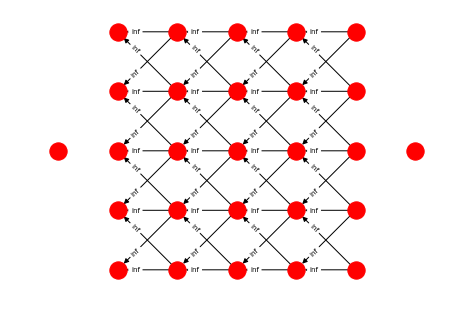

weights is [[100 102 104 106 108]
 [110 112 114 116 118]
 [120 122 124 126 128]
 [130 132 134 136 138]
 [140 142 144 146 148]]
structure is [[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


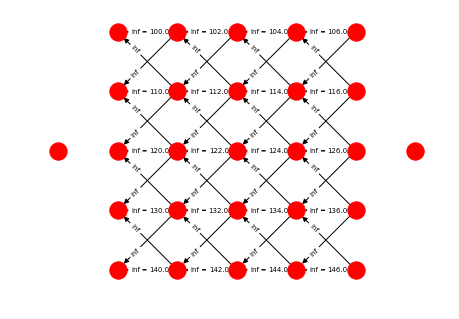

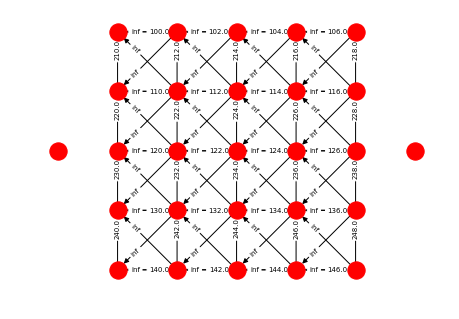

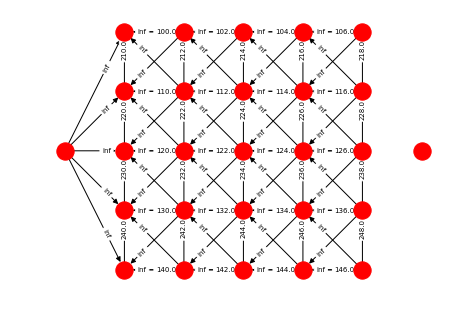

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


In [44]:
# learn how to creat graph
def create_graph():
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes((5,5))
    
    # Edges pointing backwards (left, left up and left down) with infinite
    # capacity
    structure = np.array([[np.inf, 0, 0],
                          [np.inf, 0, 0],
                          [np.inf, 0, 0]
                         ])
    g.add_grid_edges(nodeids, structure=structure, symmetric=False)
    plot_graph_2d(g, nodeids.shape)
    
    # Set a few arbitrary weights
    weights = np.array([[100, 110, 120, 130, 140]]).T + np.array([0, 2, 4, 6, 8])
    print("weights is {}".format(weights))
    
    # Edges pointing right
    structure = np.zeros((3,3))
    structure[1,2] = 1
    print("structure is {}".format(structure))
    g.add_grid_edges(nodeids, structure=structure, weights=weights, symmetric=False)
    plot_graph_2d(g, nodeids.shape)

    # Edges pointing up
    structure = np.zeros((3,3))
    structure[0,1] = 1
    g.add_grid_edges(nodeids, structure=structure, weights=weights+100, symmetric=False)
    plot_graph_2d(g, nodeids.shape)

    # Edges pointing down
    #structure = np.zeros((3,3))
    #structure[2,1] = 1
    #g.add_grid_edges(nodeids, structure=structure, weights=weights+200, symmetric=False)
    
    # Source node connected to leftmost non-terminal nodes.
    left = nodeids[:, 0]
    g.add_grid_tedges(left, np.inf, 0)
    # Sink node connected to rightmost non-terminal nodes.
    #right = nodeids[:, -1]
    #g.add_grid_tedges(right, 0, np.inf)
    
    return nodeids, g

if __name__ == '__main__':
    nodeids, g = create_graph()
    
    plot_graph_2d(g, nodeids.shape)
    
    g.maxflow()
    print(g.get_grid_segments(nodeids))

# create multiple layer graph-4connected, the pipeline will be following:
* use a subset of the image to test the graph structure and result
* apply the code on the whole image

<img src="opti_project11.png" alt="Draft" style="width: 700px;"/>

In [5]:
##########################################################show the built graph########################################################
import numpy as np
import networkx as nx

def plot_graph_2d(graph, nodes_shape, plot_weights=True, plot_terminals=True, font_size=7):
    X, Y = np.mgrid[:nodes_shape[0], :nodes_shape[1]]
    aux = np.array([Y.ravel(), X[::-1].ravel()]).T
    positions = {i: v for i, v in enumerate(aux)}
    positions['s'] = (-1, nodes_shape[0] / 2.0 - 0.5)
    positions['t'] = (nodes_shape[1], nodes_shape[0] / 2.0 - 0.5)

    nxgraph = graph.get_nx_graph()
    if not plot_terminals:
        nxgraph.remove_nodes_from(['s', 't'])

    plt.clf()
    nx.draw(nxgraph, pos=positions)

    if plot_weights:
        edge_labels = {}
        for u, v, d in nxgraph.edges(data=True):
            edge_labels[(u,v)] = d['weight']
        nx.draw_networkx_edge_labels(nxgraph,
                                     pos=positions,
                                     edge_labels=edge_labels,
                                     label_pos=0.3,
                                     font_size=font_size)

    plt.axis('equal')
    plt.show()

def plot_graph_3d(graph, nodes_shape, plot_terminal=True, plot_weights=True, font_size=7):
    w_h = nodes_shape[1] * nodes_shape[2]
    X, Y = np.mgrid[:nodes_shape[1], :nodes_shape[2]]
    aux = np.array([Y.ravel(), X[::-1].ravel()]).T
    positions = {i: v for i, v in enumerate(aux)}

    for i in range(1, nodes_shape[0]):
        for j in range(w_h):
            positions[w_h * i + j] = [positions[j][0] + 0.3 * i, positions[j][1] + 0.2 * i]

    positions['s'] = np.array([-1, nodes_shape[1] / 2.0 - 0.5])
    positions['t'] = np.array([nodes_shape[2] + 0.2 * nodes_shape[0], nodes_shape[1] / 2.0 - 0.5])

    nxg = graph.get_nx_graph()
    if not plot_terminal:
        nxg.remove_nodes_from(['s', 't'])

    nx.draw(nxg, pos=positions)
    nx.draw_networkx_labels(nxg, pos=positions)
    if plot_weights:
        edge_labels = dict([((u, v,), d['weight'])
                     for u, v, d in nxg.edges(data=True)])
        nx.draw_networkx_edge_labels(nxg, 
                                     pos=positions,
                                     edge_labels=edge_labels,
                                     label_pos=0.3,
                                     font_size=font_size)
    plt.axis('equal')
    plt.show()

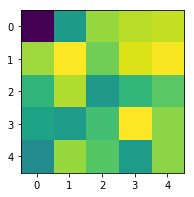

shape of pyramid img(5, 5) and the img matrix
[[ 85 145 178 183 185]
 [179 195 171 189 194]
 [157 182 144 158 167]
 [149 146 162 195 176]
 [138 178 166 146 176]]
id of nodes[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]
  [20 21 22 23 24]]

 [[25 26 27 28 29]
  [30 31 32 33 34]
  [35 36 37 38 39]
  [40 41 42 43 44]
  [45 46 47 48 49]]

 [[50 51 52 53 54]
  [55 56 57 58 59]
  [60 61 62 63 64]
  [65 66 67 68 69]
  [70 71 72 73 74]]

 [[75 76 77 78 79]
  [80 81 82 83 84]
  [85 86 87 88 89]
  [90 91 92 93 94]
  [95 96 97 98 99]]]
nodes of g 102 =? img pixel *4 which is100 + a source and a sink(2)
weight between 1 and 0 is20,
weight between 1 and 2 is20,
weight between 1 and 6 is20,
weight between 1 and 26 is1670,


In [90]:
##################################### Import and read img (select subset of image)#################################################
import numpy as np
import scipy
import scipy.misc
import imageio
import matplotlib.pyplot as plt
img=imageio.imread("pyramid_agwn_sat_255.png")
#use small size img for less computation time
img=img[25:30,25:30]
import maxflow
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()
print("shape of pyramid img{} and the img matrix".format(img.shape))
print(img)

#################################################################### Create the graph##########################################
g = maxflow.Graph[int]()
# num_label=5,k=5
nodeids = g.add_grid_nodes((4,img.shape[0],img.shape[1]))
print("id of nodes{}".format(nodeids))
def unrevel(nodenum,img):
    x=nodenum//img.shape[1]
    y=nodenum%img.shape[1]
    return(x,y)
# use 4 connected graph for each layer n-link
#add constant step V cost
#right-left assign small penality when Ip and Iq are greatly different
lamb=20
threshold=15
#kp please refer P44 of the thesis which is used to ensure the flow feasibility
kp=np.zeros(img.shape)
u_pq_matrix=np.zeros(img.shape)
for i in range(u_pq_matrix.shape[0]):
    for j in range(u_pq_matrix.shape[1]-1):
        if (np.abs(img[i][j]/2-img[i][j+1]/2)>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2

structure = np.zeros((3,3))
structure[1,2] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[:,u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]]
u_pq_matrix=u_pq_matrix[:,0:u_pq_matrix.shape[1]-1]
u_pq_matrix=np.c_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
    
#up-down
lamb=20
threshold=15
u_pq_matrix=np.zeros(img.shape)
for i in range(u_pq_matrix.shape[0]-1):
    for j in range(u_pq_matrix.shape[1]):
        if (np.abs(img[i][j]/2-img[i+1][j]/2)>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2

structure = np.zeros((3,3))
structure[2,1] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]:]
u_pq_matrix=u_pq_matrix[0:u_pq_matrix.shape[1]-1:]
u_pq_matrix=np.r_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
# make sure kp is larger
kp=kp+np.ones(kp.shape)*10

    
#add t-link
#link source
k=5
source_weight=np.zeros(img.shape)
for i in range(source_weight.shape[0]):
    for j in range(source_weight.shape[1]):
        source_weight[i][j]=kp[i][j]+np.power(img[i][j]-65,2)
g.add_grid_tedges(nodeids[0], source_weight, 0)

# #  not really necessary
# def unravel_4layers(nodenum,img):
#     layer=nodenum//(img.shape[0]*img.shape[1])
#     x=(nodenum%(img.shape[0]*img.shape[1]))//img.shape[1]
#     y=(nodenum%(img.shape[0]*img.shape[1]))%img.shape[1]
#     return(x,y)

L=[65,105,145,185,225]
for l in range(k-2):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            g.add_edge(nodeids[l][i][j],nodeids[l+1][i][j],kp[i][j]+np.power(L[l+1]-img[i][j],2),kp[i][j]+np.power(L[l+1]-img[i][j],2))
            #test unit
            #print("layer,i,j is{}{}{}".format(l,i,j))
            #print("node {} and node {}".format(nodeids[l][i][j],nodeids[l+1][i][j]))
            #print("label {}".format(L[l+1]))

sink_weight=np.zeros(img.shape)
for i in range(sink_weight.shape[0]):
    for j in range(sink_weight.shape[1]):
        sink_weight[i][j]=kp[i][j]+np.power(img[i][j]-225,2)
g.add_grid_tedges(nodeids[3], 0,sink_weight)


#check the graph
g_nx=g.get_nx_graph()
print("nodes of g {} =? img pixel *4 which is{} + a source and a sink(2)".format(g_nx.number_of_nodes(),img.shape[0]*img.shape[1]*4))
#the node are numbers from 0 to 41599, with 's', and 't'
#print(list(g_nx.nodes))
#print(list(g_nx.adj[1]))
for n, nbrs in g_nx.adj.items():
    if(n==1):
        #print(nbrs.items())   
        for nbr, eattr in nbrs.items():
            wt = eattr['weight']
            print("weight between {} and {} is{},".format(n,nbr,wt))


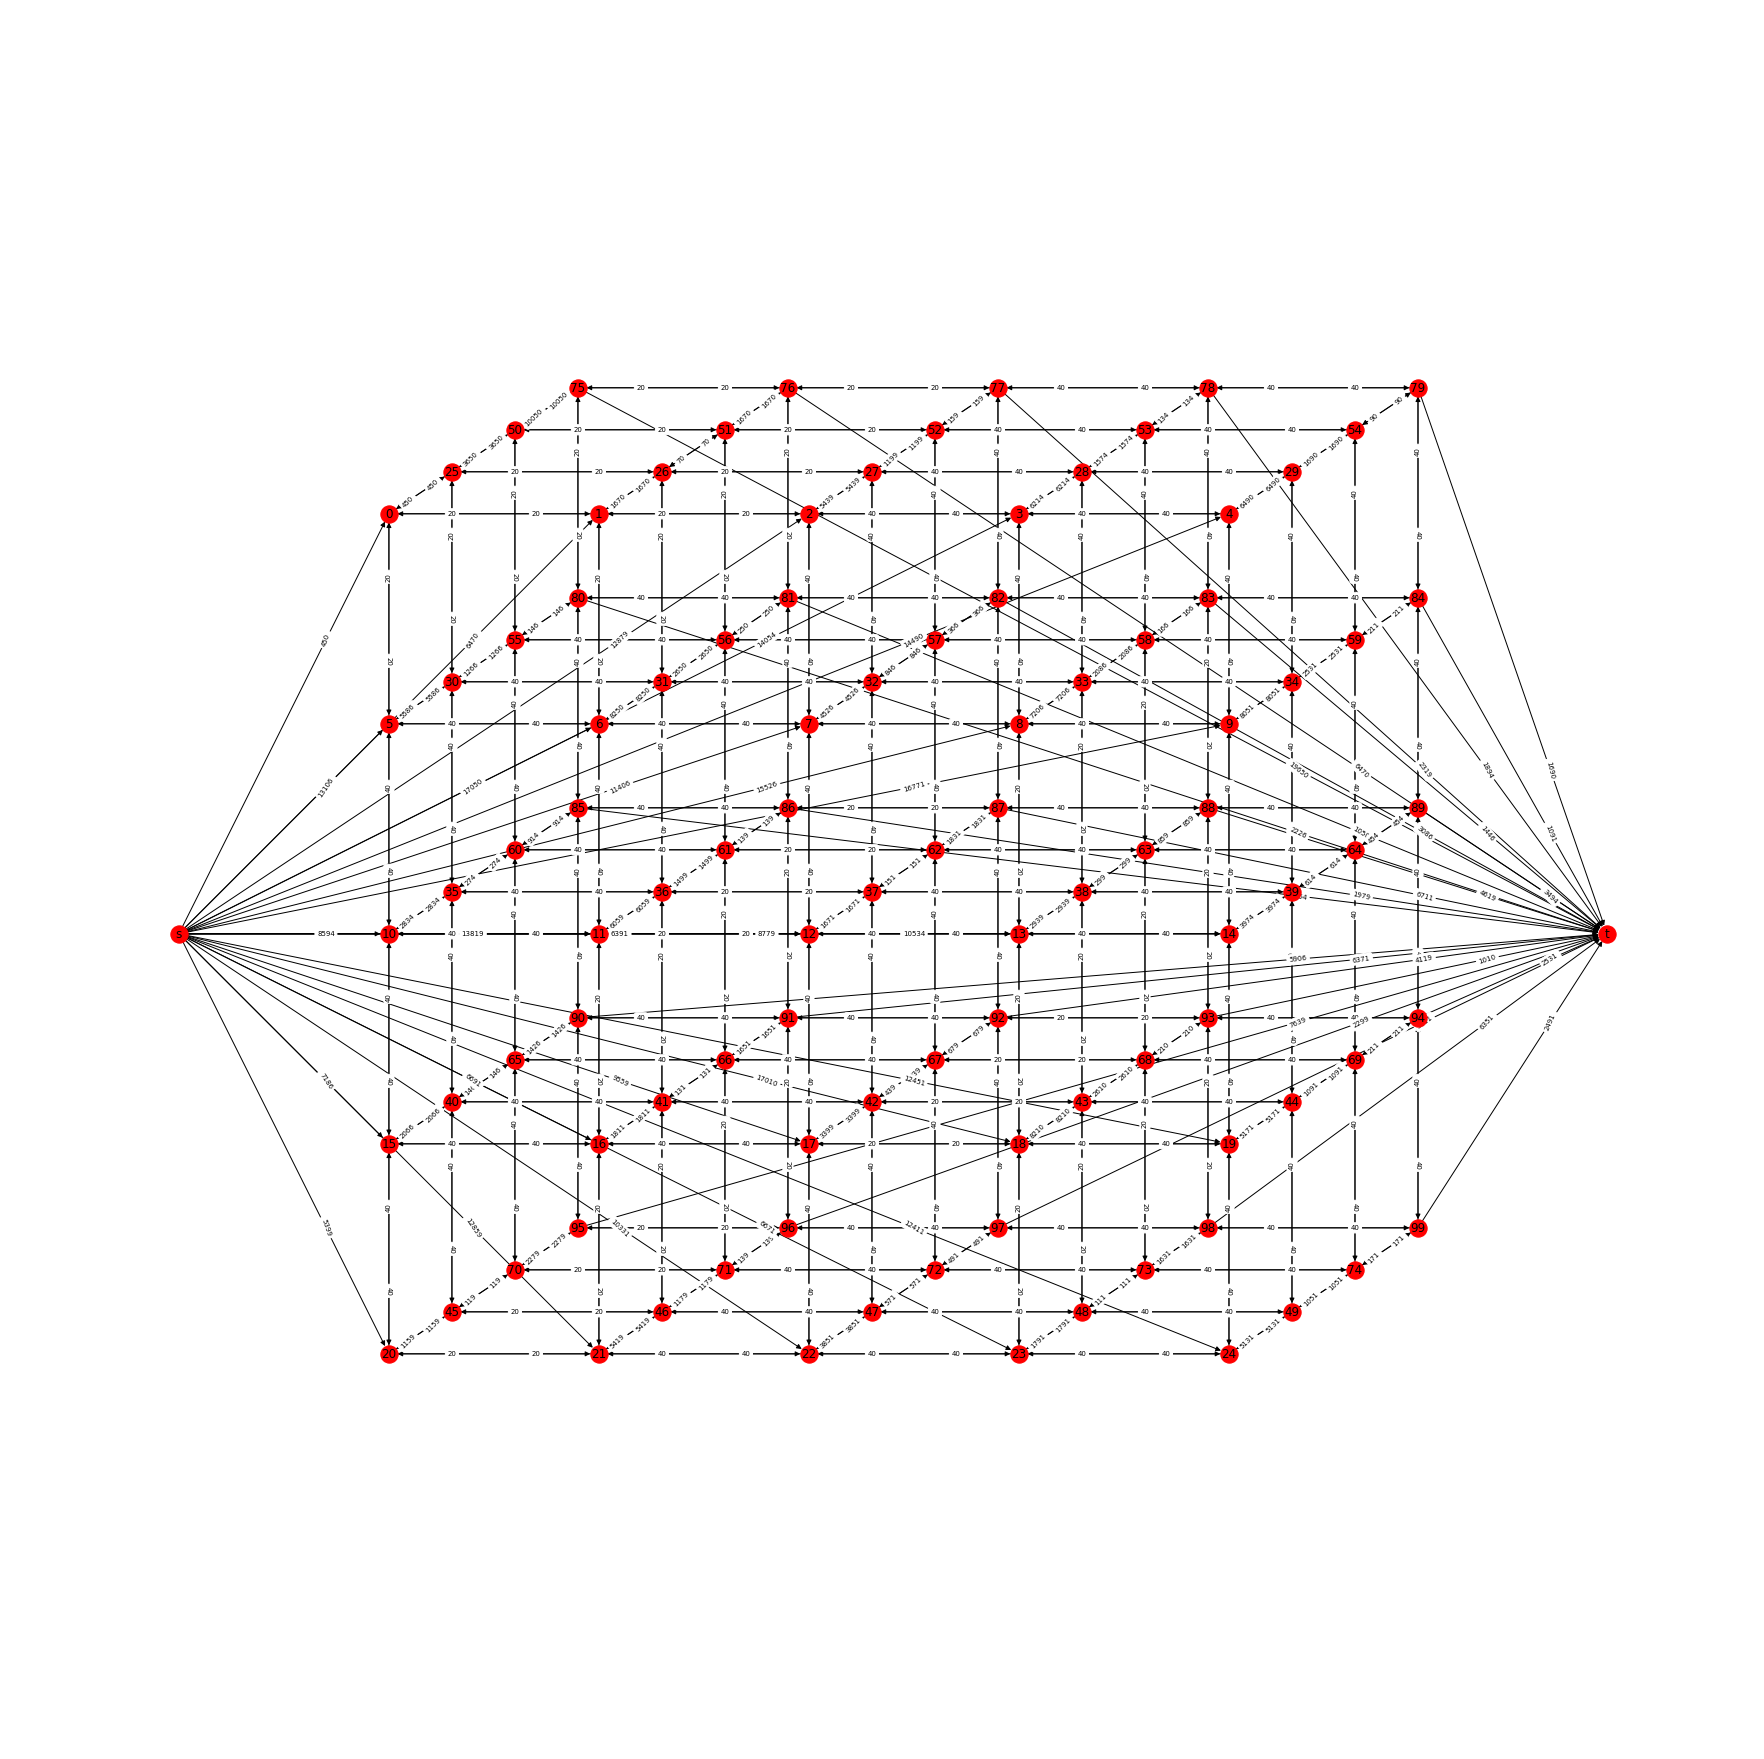

In [91]:
#graph representation
plt.figure(figsize=(24,24))
plot_graph_3d(g,(4,img.shape[0],img.shape[1]))

[[105. 145. 185. 185. 185.]
 [185. 185. 185. 185. 185.]
 [145. 185. 145. 145. 185.]
 [145. 145. 145. 185. 185.]
 [145. 185. 185. 145. 185.]]


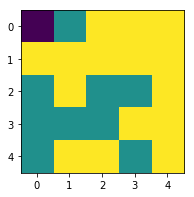

In [96]:
################################################ Max Flow Cut and image Reconstruction ############################################
# resource is 0 (dark), sink (t-node) is 255
#false means the node belons to resource
g.maxflow()
sgm = g.get_grid_segments(nodeids)
img_recst=np.ones(img.shape)*255
for i in range(sgm.shape[1]):
    for j in range(sgm.shape[2]):
        for k in range(sgm.shape[0]):
            if sgm[k][i][j]==True:
                img_recst[i][j]=L[k]
                break
            else:
                continue
print(img_recst)
plt.figure(figsize=(3,3))
plt.imshow(img_recst)
plt.show()        

## We apply this to the whole graph 

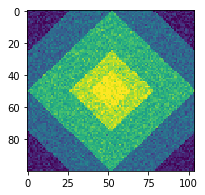

shape of pyramid img(100, 104) and the img matrix
[[17 25 38 ... 24 23  2]
 [19  6 12 ...  0 27 39]
 [18  4 46 ...  0 26 18]
 ...
 [ 8  0  0 ... 25 11  5]
 [33 25 67 ... 12  0 15]
 [ 5  3  0 ... 21  0 26]]
nodes of g 41602 =? img pixel *4 which is41600 + a source and a sink(2)
weight between 1 and 0 is6000,
weight between 1 and 2 is6000,
weight between 1 and 105 is6000,
weight between 1 and 10401 is30410,


In [192]:
############################ Import and read img (select subset of image)#################################################
import numpy as np
import scipy
import scipy.misc
import imageio
import matplotlib.pyplot as plt
img=imageio.imread("pyramid_agwn_sat_255.png")
#use small size img for less computation time
img=img
import maxflow
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()
print("shape of pyramid img{} and the img matrix".format(img.shape))
print(img)

#################################################################### Create the graph##########################################
g = maxflow.Graph[int]()
# num_label=5,k=5
nodeids = g.add_grid_nodes((4,img.shape[0],img.shape[1]))
#print("id of nodes{}".format(nodeids))

# use 4 connected graph for each layer n-link
#add constant step V cost
#right-left assign small penality when Ip and Iq are greatly different
lamb=3000
threshold=20
#kp please refer P44 of the thesis which is used to ensure the flow feasibility
kp=np.zeros(img.shape)
u_pq_matrix=np.zeros(img.shape)
for i in range(u_pq_matrix.shape[0]):
    for j in range(u_pq_matrix.shape[1]-1):
        if (np.abs(img[i][j]/2-img[i][j+1]/2)>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2

structure = np.zeros((3,3))
structure[1,2] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[:,u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]]
u_pq_matrix=u_pq_matrix[:,0:u_pq_matrix.shape[1]-1]
u_pq_matrix=np.c_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
    
#up-down
u_pq_matrix=np.zeros(img.shape)
for i in range(u_pq_matrix.shape[0]-1):
    for j in range(u_pq_matrix.shape[1]):
        if (np.abs(img[i][j]/2-img[i+1][j]/2)>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2

structure = np.zeros((3,3))
structure[2,1] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]:]
u_pq_matrix=u_pq_matrix[0:u_pq_matrix.shape[1]-1:]
u_pq_matrix=np.r_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
# make sure kp is larger
kp=kp+np.ones(kp.shape)*10

    
#############################################################add t-link##################################################################
#link source
k=5
source_weight=np.zeros(img.shape)
for i in range(source_weight.shape[0]):
    for j in range(source_weight.shape[1]):
        source_weight[i][j]=kp[i][j]+np.power(img[i][j]-65,2)
g.add_grid_tedges(nodeids[0], source_weight, 0)

# #  not really necessary
# def unravel_4layers(nodenum,img):
#     layer=nodenum//(img.shape[0]*img.shape[1])
#     x=(nodenum%(img.shape[0]*img.shape[1]))//img.shape[1]
#     y=(nodenum%(img.shape[0]*img.shape[1]))%img.shape[1]
#     return(x,y)

L=[65,105,145,185,225]
for l in range(k-2):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            g.add_edge(nodeids[l][i][j],nodeids[l+1][i][j],kp[i][j]+np.power(L[l+1]-img[i][j],2),kp[i][j]+np.power(L[l+1]-img[i][j],2))
            #test unit
            #print("layer,i,j is{}{}{}".format(l,i,j))
            #print("node {} and node {}".format(nodeids[l][i][j],nodeids[l+1][i][j]))
            #print("label {}".format(L[l+1]))

sink_weight=np.zeros(img.shape)
for i in range(sink_weight.shape[0]):
    for j in range(sink_weight.shape[1]):
        sink_weight[i][j]=kp[i][j]+np.power(img[i][j]-225,2)
g.add_grid_tedges(nodeids[3], 0,sink_weight)


#######################################################check the graph######################################################################
g_nx=g.get_nx_graph()
print("nodes of g {} =? img pixel *4 which is{} + a source and a sink(2)".format(g_nx.number_of_nodes(),img.shape[0]*img.shape[1]*4))
#the node are numbers from 0 to 41599, with 's', and 't'
#print(list(g_nx.nodes))
#print(list(g_nx.adj[1]))
for n, nbrs in g_nx.adj.items():
    if(n==1):
        #print(nbrs.items())   
        for nbr, eattr in nbrs.items():
            wt = eattr['weight']
            print("weight between {} and {} is{},".format(n,nbr,wt))


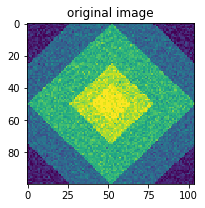

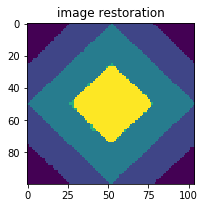

In [194]:
################################################ Max Flow Cut and image Reconstruction ############################################
# resource is 0 (dark), sink (t-node) is 255
#false means the node belons to resource
g.maxflow()
sgm = g.get_grid_segments(nodeids)
img_recst=np.ones(img.shape)*255
for i in range(sgm.shape[1]):
    for j in range(sgm.shape[2]):
        for k in range(sgm.shape[0]):
            if sgm[k][i][j]==True:
                img_recst[i][j]=L[k]
                break
            else:
                continue
#print(img_recst[30])
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title("original image")
plt.show()      
plt.figure(figsize=(3,3))
plt.imshow(img_recst)
plt.title("image restoration")
plt.show()        

## The Result is obtained by continuously optimising the parameters (This can be a optimal problem by using dynamic programing (In fact, I did a greedy algo which is of low quality so I will not post it here))
## Stereo Disparity Labeling
* we follow the same pipeline


<img src="opti_project2.png" alt="Draft" style="width: 750px;"/>

In [220]:
## using the example stero unary potential as t-link weights matrix
## using a maximum disparity window of 8.

def stereo_unaries(img1, img2):
    differences = []
    max_disp = 8
    for disp in np.arange(max_disp):
        #print(disp)
        if disp == 0:
            diff = np.sum((img1 - img2) ** 2, axis=2)
        else:
            diff = np.sum((img1[:, 2 * disp:, :] - img2[:, :-2 * disp, :]) **
                    2, axis=2)
        if disp != max_disp - 1:
            diff = diff[:, max_disp - disp - 1:disp - max_disp + 1]
        differences.append(diff)
    return np.dstack(differences).copy("C")

img1 = imageio.imread("scene1.row3.col1.ppm") / 255.
img2 = imageio.imread("scene1.row3.col2.ppm") / 255.

unaries = (stereo_unaries(img1, img2) * 100).astype(np.int32)
print("img1.shape = {}",format(img1.shape))
print(unaries[:,:,1])
#plt.figure()
## you have 8 such images
#plt.imshow(unaries[:,:,7])
#plt.show()

img1.shape = {} (288, 384, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 0 4]
 [0 0 0 ... 0 0 1]]


In [232]:
##############################################graph representation cell (using small size img)###########################################

#####################################################read image and create diff matrix################################################
def stereo_unaries(img1, img2):
    differences = []
    max_disp = 8
    for disp in np.arange(max_disp):
        #print(disp)
        if disp == 0:
            diff = np.sum((img1 - img2) ** 2, axis=2)
        else:
            diff = np.sum((img1[:, 2 * disp:, :] - img2[:, :-2 * disp, :]) **
                    2, axis=2)
        if disp != max_disp - 1:
            diff = diff[:, max_disp - disp - 1:disp - max_disp + 1]
        differences.append(diff)
    return np.dstack(differences).copy("C")

img1 = imageio.imread("scene1.row3.col1.ppm") / 255.
img2 = imageio.imread("scene1.row3.col2.ppm") / 255.

unaries = (stereo_unaries(img1, img2) * 100).astype(np.int32)
img=img1[100:104,100:104]
unaries=unaries[100:104,100:104,:]

####################################################Graph construction###############################################################
g = maxflow.Graph[int]()
# num_label=5,
k=8

nodeids = g.add_grid_nodes((k-1,img.shape[0],img.shape[1]))
#print("id of nodes{}".format(nodeids))

# use 4 connected graph for each layer n-link
#add constant step V cost
#right-left assign small penality when Ip and Iq are greatly different
lamb=300
threshold=0.2

#to note img.shape=(288, 384, 3)
kp=np.zeros((img.shape[0],img.shape[1]))
u_pq_matrix=np.zeros((img.shape[0],img.shape[1]))
for i in range(u_pq_matrix.shape[0]):
    for j in range(u_pq_matrix.shape[1]-1):
        if (np.linalg.norm(img[i][j]-img[i][j+1])>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2
            
print("estimate threshold {}".format(u_pq_matrix))

structure = np.zeros((3,3))
structure[1,2] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[:,u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]]
u_pq_matrix=u_pq_matrix[:,0:u_pq_matrix.shape[1]-1]
u_pq_matrix=np.c_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
    
#up-down
u_pq_matrix=np.zeros((img.shape[0],img.shape[1]))
for i in range(u_pq_matrix.shape[0]-1):
    for j in range(u_pq_matrix.shape[1]):
        if (np.linalg.norm(img[i][j]-img[i+1][j])>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2

structure = np.zeros((3,3))
structure[2,1] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]:]
u_pq_matrix=u_pq_matrix[0:u_pq_matrix.shape[1]-1:]
u_pq_matrix=np.r_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
# make sure kp is larger
kp=kp+np.ones(kp.shape)*10

    
#############################################################add t-link##################################################################
#link source
g.add_grid_tedges(nodeids[0], kp+unaries[:,:,0], 0)


for l in range(k-2):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            g.add_edge(nodeids[l][i][j],nodeids[l+1][i][j],kp[i][j]+unaries[i,j,l+1],kp[i][j]+unaries[i,j,l+1])
            #test unit
            #print("layer,i,j is{}{}{}".format(l,i,j))
            #print("node {} and node {}".format(nodeids[l][i][j],nodeids[l+1][i][j]))
            #print("label {}".format(L[l+1]))


g.add_grid_tedges(nodeids[k-2], 0,kp+unaries[:,:,k-1])


estimate threshold [[600. 600. 600.   0.]
 [600. 600. 600.   0.]
 [600. 600. 600.   0.]
 [600. 600. 600.   0.]]


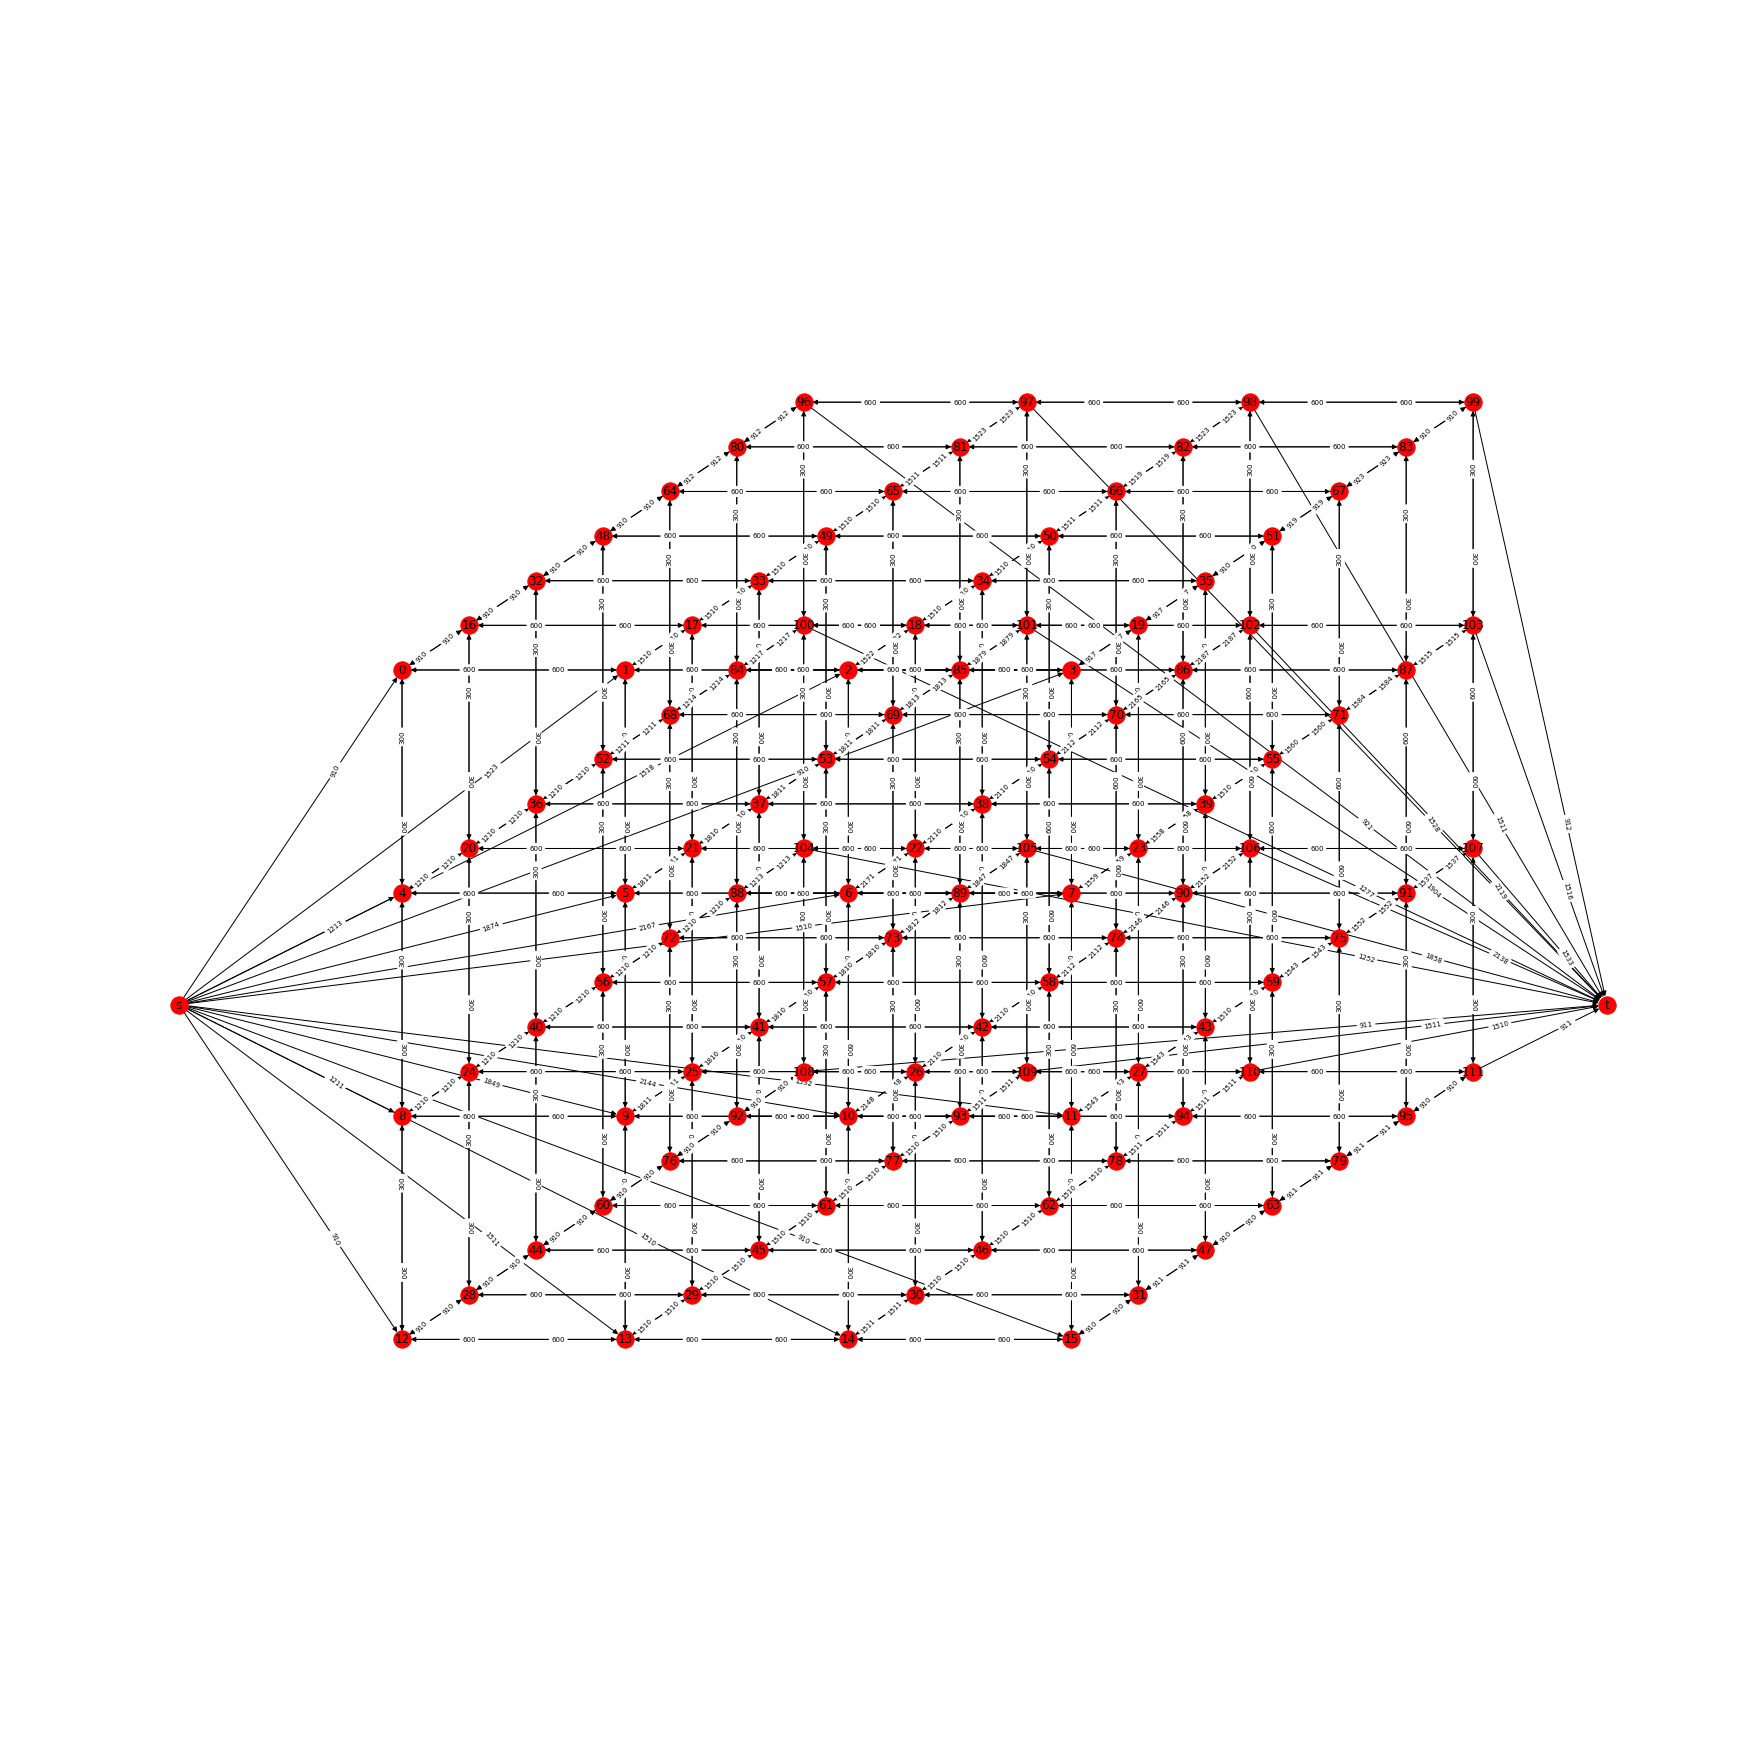

In [233]:
#graph representation
plt.figure(figsize=(24,24))
plot_graph_3d(g,(k-1,img.shape[0],img.shape[1]))

## Apply the Algo on the whole image

In [271]:
##############################################graph representation cell (using small size img)###########################################

#####################################################read image and create diff matrix################################################
def stereo_unaries(img1, img2):
    differences = []
    max_disp = 8
    for disp in np.arange(max_disp):
        #print(disp)
        if disp == 0:
            diff = np.sum((img1 - img2) ** 2, axis=2)
        else:
            diff = np.sum((img1[:, 2 * disp:, :] - img2[:, :-2 * disp, :]) **
                    2, axis=2)
        if disp != max_disp - 1:
            diff = diff[:, max_disp - disp - 1:disp - max_disp + 1]
        differences.append(diff)
    return np.dstack(differences).copy("C")

img1 = imageio.imread("scene1.row3.col1.ppm") / 255.
img2 = imageio.imread("scene1.row3.col2.ppm") / 255.

unaries = (stereo_unaries(img1, img2) * 100).astype(np.int32)
img=img1[:,7:-7,:]


####################################################Graph construction###############################################################
g = maxflow.Graph[int]()
# num_label=5,
k=8

nodeids = g.add_grid_nodes((k-1,img.shape[0],img.shape[1]))
#print("id of nodes{}".format(nodeids))

# use 4 connected graph for each layer n-link
#add constant step V cost
#right-left assign small penality when Ip and Iq are greatly different
lamb=2.4
threshold=0.002

#to note img.shape=(288, 384, 3)
kp=np.zeros((img.shape[0],img.shape[1]))
u_pq_matrix=np.zeros((img.shape[0],img.shape[1]))
for i in range(u_pq_matrix.shape[0]):
    for j in range(u_pq_matrix.shape[1]-1):
        if (np.linalg.norm(img[i][j]-img[i][j+1])>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2
            
print("estimate threshold {}".format(u_pq_matrix))

structure = np.zeros((3,3))
structure[1,2] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[:,u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]]
u_pq_matrix=u_pq_matrix[:,0:u_pq_matrix.shape[1]-1]
u_pq_matrix=np.c_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
    
#up-down
u_pq_matrix=np.zeros((img.shape[0],img.shape[1]))
for i in range(u_pq_matrix.shape[0]-1):
    for j in range(u_pq_matrix.shape[1]):
        if (np.linalg.norm(img[i][j]-img[i+1][j])>threshold):
            u_pq_matrix[i][j]=lamb
        else:
            u_pq_matrix[i][j]=lamb*2

structure = np.zeros((3,3))
structure[2,1] = 1     
for i in range(nodeids.shape[0]):
    g.add_grid_edges(nodeids[i],structure=structure, weights=u_pq_matrix,symmetric=True)
    
kp=kp+u_pq_matrix
#print(u_pq_matrix)
a=u_pq_matrix[u_pq_matrix.shape[1]-1:u_pq_matrix.shape[1]:]
u_pq_matrix=u_pq_matrix[0:u_pq_matrix.shape[1]-1:]
u_pq_matrix=np.r_[a,u_pq_matrix]
#print(u_pq_matrix)
kp=kp+u_pq_matrix
# make sure kp is larger
kp=kp+np.ones(kp.shape)*10

    
#############################################################add t-link##################################################################
#link source
g.add_grid_tedges(nodeids[0], kp+unaries[:,:,0], 0)


for l in range(k-2):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            g.add_edge(nodeids[l][i][j],nodeids[l+1][i][j],kp[i][j]+unaries[i,j,l+1],kp[i][j]+unaries[i,j,l+1])
            #test unit
            #print("layer,i,j is{}{}{}".format(l,i,j))
            #print("node {} and node {}".format(nodeids[l][i][j],nodeids[l+1][i][j]))
            #print("label {}".format(L[l+1]))


g.add_grid_tedges(nodeids[k-2], 0,kp+unaries[:,:,k-1])
print("graph succeed constructed")

estimate threshold [[2.4 4.8 4.8 ... 2.4 2.4 0. ]
 [4.8 4.8 4.8 ... 2.4 2.4 0. ]
 [4.8 4.8 4.8 ... 2.4 2.4 0. ]
 ...
 [2.4 2.4 2.4 ... 2.4 2.4 0. ]
 [2.4 4.8 2.4 ... 2.4 2.4 0. ]
 [2.4 2.4 2.4 ... 2.4 2.4 0. ]]
graph succeed constructed


[  0  30  60  90 120 150 180]


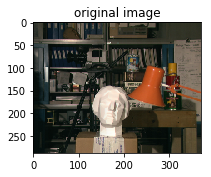

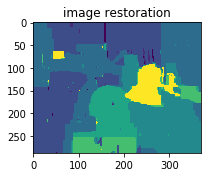

In [272]:
################################################ Max Flow Cut and image Reconstruction ############################################
# resource is 0 (dark), sink (t-node) is 255
#false means the node belons to resource
g.maxflow()
sgm = g.get_grid_segments(nodeids)
#print(sgm)
L=np.array([0,1,2,3,4,5,6])*30
print(L)
img_recst=np.ones((img.shape[0],img.shape[1]))*255
for i in range(sgm.shape[1]):
    for j in range(sgm.shape[2]):
        for k in range(sgm.shape[0]):
            if sgm[k][i][j]==True:
                img_recst[i][j]=L[k]
                break
            else:
                continue
#print(img_recst)
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title("original image")
plt.show()      
plt.figure(figsize=(3,3))
plt.imshow(img_recst)
plt.title("image restoration")
plt.show()        

# The visual corresponce works quite well, but we can still see some noise(the compromise of smoothness and accuracy)
# below are test cells

<IPython.core.display.Javascript object>


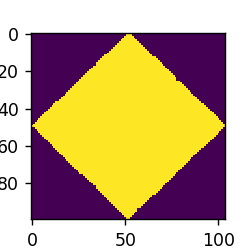

In [208]:
# Create the graph.
g = maxflow.Graph[int]()
# num_label=5,k=4
nodeids = g.add_grid_nodes((img.shape[0]*img.shape[1],4))
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, 50)
# Add the terminal edges. The image pixels are the capacities
# of the edges from the source node. The inverted image pixels
# are the capacities of the edges to the sink node.
g.add_grid_tedges(nodeids, img, (255-img))
# Find the maximum flow.
g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
%matplotlib notebook
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
plt.figure(figsize=(2,2))
plt.imshow(img2)

## We can modify the parameter $\lambda$ to better sever the image

<IPython.core.display.Javascript object>


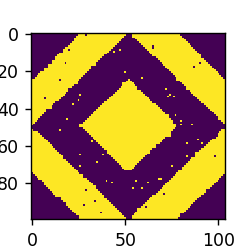

In [222]:
g = maxflow.Graph[int]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img.shape)
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, 50)
# Add the terminal edges. The image pixels are the capacities
# of the edges from the source node. The inverted image pixels
# are the capacities of the edges to the sink node.
g.add_grid_tedges(nodeids, 2*img, 2*(255-img))
# Find the maximum flow.
g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
%matplotlib notebook
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.show()